In [1]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
import scipy.stats as st
from collections import defaultdict
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from scipy.stats import poisson, norm
from scipy.spatial import ConvexHull
import fnmatch


import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))

def vector_angle_reconstruct(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi


In [2]:
arrays = {}

In [3]:
path = '/home/jiajun/muography/data/nine_v5/'
file = 'ten_2x4x8_free_0.edm4hep.root'
with ur.open(path+file+":events") as f:
    arrays['large'] = f.arrays(filter_name=["MuographyHits.energy", "MuographyHitsContributions.time", 
                                   "MuographyHits.position.x", "MuographyHits.position.y", "MuographyHits.position.z", 
                                   "MCParticles.PDG", "MCParticles.generatorStatus", 
                                   "MCParticles.momentum.x", "MCParticles.momentum.y", "MCParticles.momentum.z", 
                                   "MCParticles.vertex.x", "MCParticles.vertex.y", "MCParticles.vertex.z", 
                                   "MCParticles.mass"])
df = pd.read_pickle(path+'free_merge.pkl')
df

detector  theta_reco    phi_reco  theta_true    phi_true  \
0               0   70.929887   45.000000   39.802006   59.988968   
1               0   23.532349 -180.000000   30.339361 -150.249908   
2               0   12.511747 -135.000000   17.354342 -135.177109   
3               0   72.280912  -45.000000   74.176018  -43.531967   
4               0   10.061412  -90.000000    9.505741 -103.976913   
...           ...         ...         ...         ...         ...   
3581555         9    9.456749  156.503003   22.321169  106.811394   
3581556         9    0.000000    0.000000   25.364285  -52.617447   
3581557         9   65.685360  135.000000   45.479633  148.041794   
3581558         9    0.000000    0.000000   23.353302  -74.424568   
3581559         9   18.857392  135.000000   33.053719  129.123871   

         event_energy  theta_energy  
0            0.002277     53.377453  
1            0.004024     26.697328  
2            0.006220     15.821550  
3            0.001220           NaN  
4            0.019883     -5.996734  
...               ...           ...  
3581555      0.000316           NaN  
3581556      0.012065      4.039652  
3581557      0.002088           NaN  
3581558      0.003051     61.375777  
3581559      0.002158           NaN  

[3581560 rows x 7 columns]

In [4]:
path = '/home/jiajun/muography/data/nine_v5_1/'
file = 'ten_4x16_free_0.edm4hep.root'
with ur.open(path+file+":events") as f:
    arrays['small'] = f.arrays(filter_name=["MuographyHits.energy", "MuographyHitsContributions.time", 
                                   "MuographyHits.position.x", "MuographyHits.position.y", "MuographyHits.position.z", 
                                   "MCParticles.PDG", "MCParticles.generatorStatus", 
                                   "MCParticles.momentum.x", "MCParticles.momentum.y", "MCParticles.momentum.z", 
                                   "MCParticles.vertex.x", "MCParticles.vertex.y", "MCParticles.vertex.z", 
                                   "MCParticles.mass"])
dg = pd.read_pickle(path+'free_merge.pkl')
dg

detector  theta_reco   phi_reco  theta_true    phi_true  event_energy  \
0              0   30.158150   45.00000   39.802006   59.988968      0.002107   
1              0   31.850677 -135.00000   30.339361 -150.249908      0.002837   
2              0   83.556644  -45.00000   74.176018  -43.531967      0.001773   
3              0   42.360543 -109.85705   43.858597 -101.505035      0.010039   
4              0   30.468386   19.85705   39.752525   30.140015      0.002931   
...          ...         ...        ...         ...         ...           ...   
418335         9   23.962413 -135.00000   29.018061 -144.910782      0.004535   
418336         9   48.508814   25.14328   46.765751   17.462227      0.001902   
418337         9   21.337586   -0.00000   21.945753   -8.827245      0.002661   
418338         9   57.978084  160.14328   54.406967  163.839584      0.003223   
418339         9    0.000000    0.00000   42.292542 -174.122482      0.000737   

        theta_energy  
0          30.155974  
1          20.575162  
2          42.194212  
3           0.308096  
4          19.797213  
...              ...  
418335     41.519240  
418336     77.111411  
418337     65.722573  
418338     57.933470  
418339     97.050121  

[418340 rows x 7 columns]

/tmp/ipykernel_728529/3312401314.py:28: RuntimeWarning: divide by zero encountered in divide
  coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.01,0,20),sigma=1/y)
/tmp/ipykernel_728529/3312401314.py:46: RuntimeWarning: divide by zero encountered in divide
  coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.01,0,20),sigma=1/y)


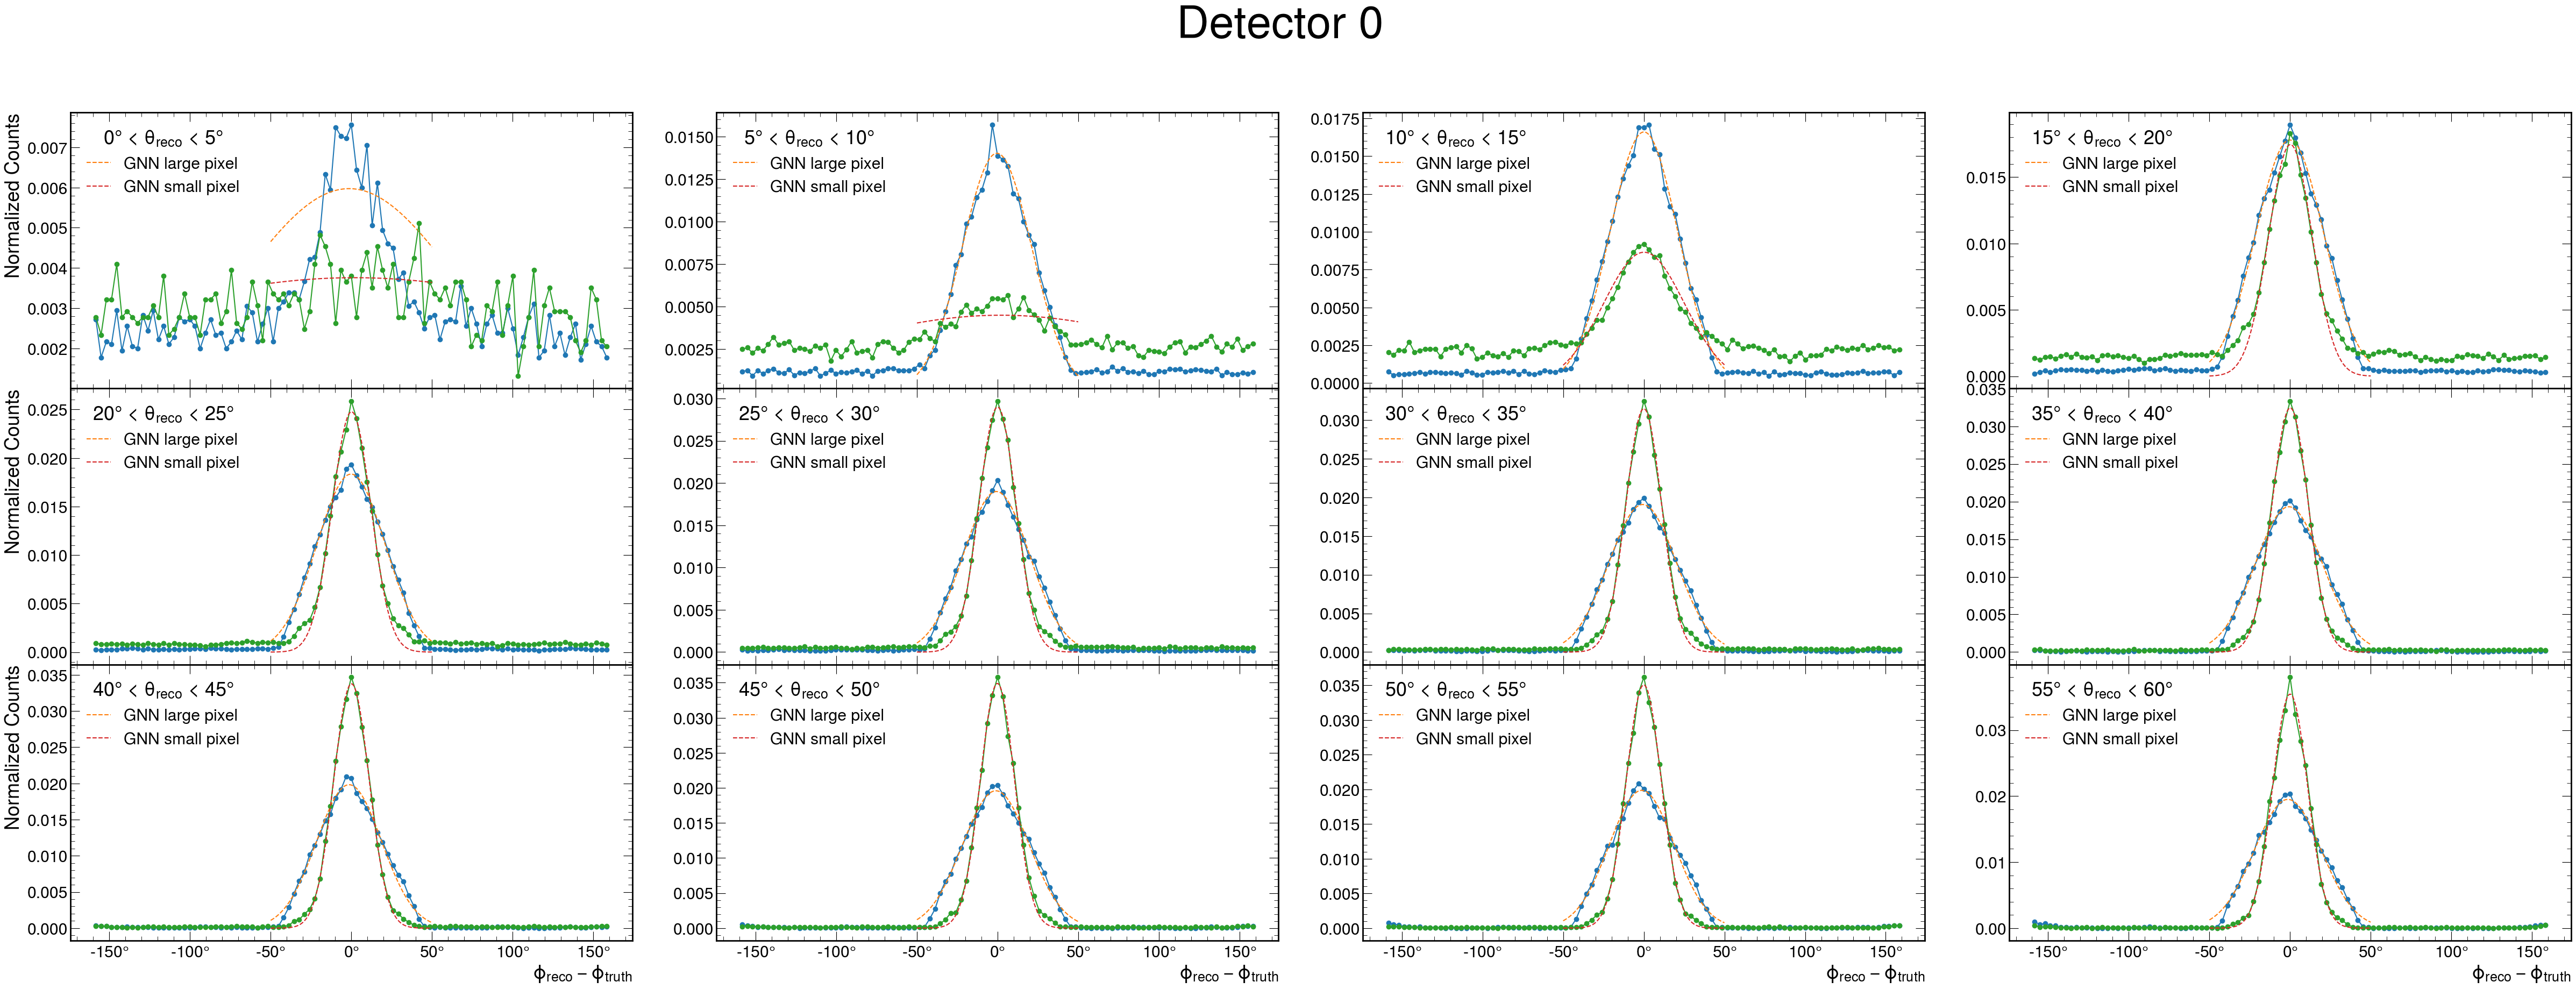

In [37]:
def theta_from_energy(E, A, k, C):
    return -(1.0 / k) * np.log((E - C) / A)
    
binsize = 5
bins= []
rms = []
mea = []
fits = []
error = []
binnum = np.linspace(-160,160,100)
max_bin = 65
for j in range(1):
    fig, ax = plt.subplots(3,4,figsize=(60,20),sharex=True,sharey=False)

    for i in range(12):
        plt.sca(ax[i//4,i%4])
        bins.append(i*binsize+5+binsize/2)
        detector_cut = df['detector']==j
        cut = (((i) * binsize <= df['theta_true'][detector_cut]) & (df['theta_true'][detector_cut] < (i+1) * binsize))

        y,x = np.histogram(df['phi_reco'][detector_cut][cut]-df['phi_true'][detector_cut][cut],bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o')
        means = df['phi_reco'][detector_cut][cut]-df['phi_true'][detector_cut][cut]
        rms.append(np.std(means))
        mea.append(np.mean(means))
        
        coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.01,0,20),sigma=1/y)
        fits.append(coeff)
        error.append(covar[2][2])
        x=np.linspace(-50,50,100)
        plt.errorbar(x,gaus(x,*coeff),fmt='--',label='GNN large pixel')
        
    for i in range(12):
        plt.sca(ax[i//4,i%4])
        detector_cut = dg['detector']==j
        cut = (((i) * binsize <= dg['theta_true'][detector_cut]) & (dg['theta_true'][detector_cut] < (i+1) * binsize))

        y,x = np.histogram(dg['phi_reco'][detector_cut][cut]-dg['phi_true'][detector_cut][cut],bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o')
        means = dg['phi_reco'][detector_cut][cut]-dg['phi_true'][detector_cut][cut]
        rms.append(np.std(means))
        mea.append(np.mean(means))
        
        coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.01,0,20),sigma=1/y)
        fits.append(coeff)
        error.append(covar[2][2])
        x=np.linspace(-50,50,100)
        plt.errorbar(x,gaus(x,*coeff),fmt='--',label='GNN small pixel')
        
        plt.xlabel(r'$\phi_{reco} - \phi_{truth}$')
        plt.legend(title=rf'{i * binsize}$\degree$ < $\theta_{{reco}}$ < {(i+1) * binsize}$\degree$', loc = 'upper left')
        #plt.xlim(-50,50)
    fig.subplots_adjust(wspace=0.15,hspace=0)
    
    ax[0,0].set_ylabel('Normalized Counts')
    ax[1,0].set_ylabel('Normalized Counts')
    ax[2,0].set_ylabel('Normalized Counts')
    
    import matplotlib.ticker as mticker
    def degree_formatter(x, pos):
        return rf"{int(x)}$\degree$" 
    for axi in ax.flat:
        axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))
    
    #plt.savefig('ThetaResolution_differential.pdf',format='pdf')
    plt.suptitle(f'Detector {j}', fontsize=60)
    plt.show()

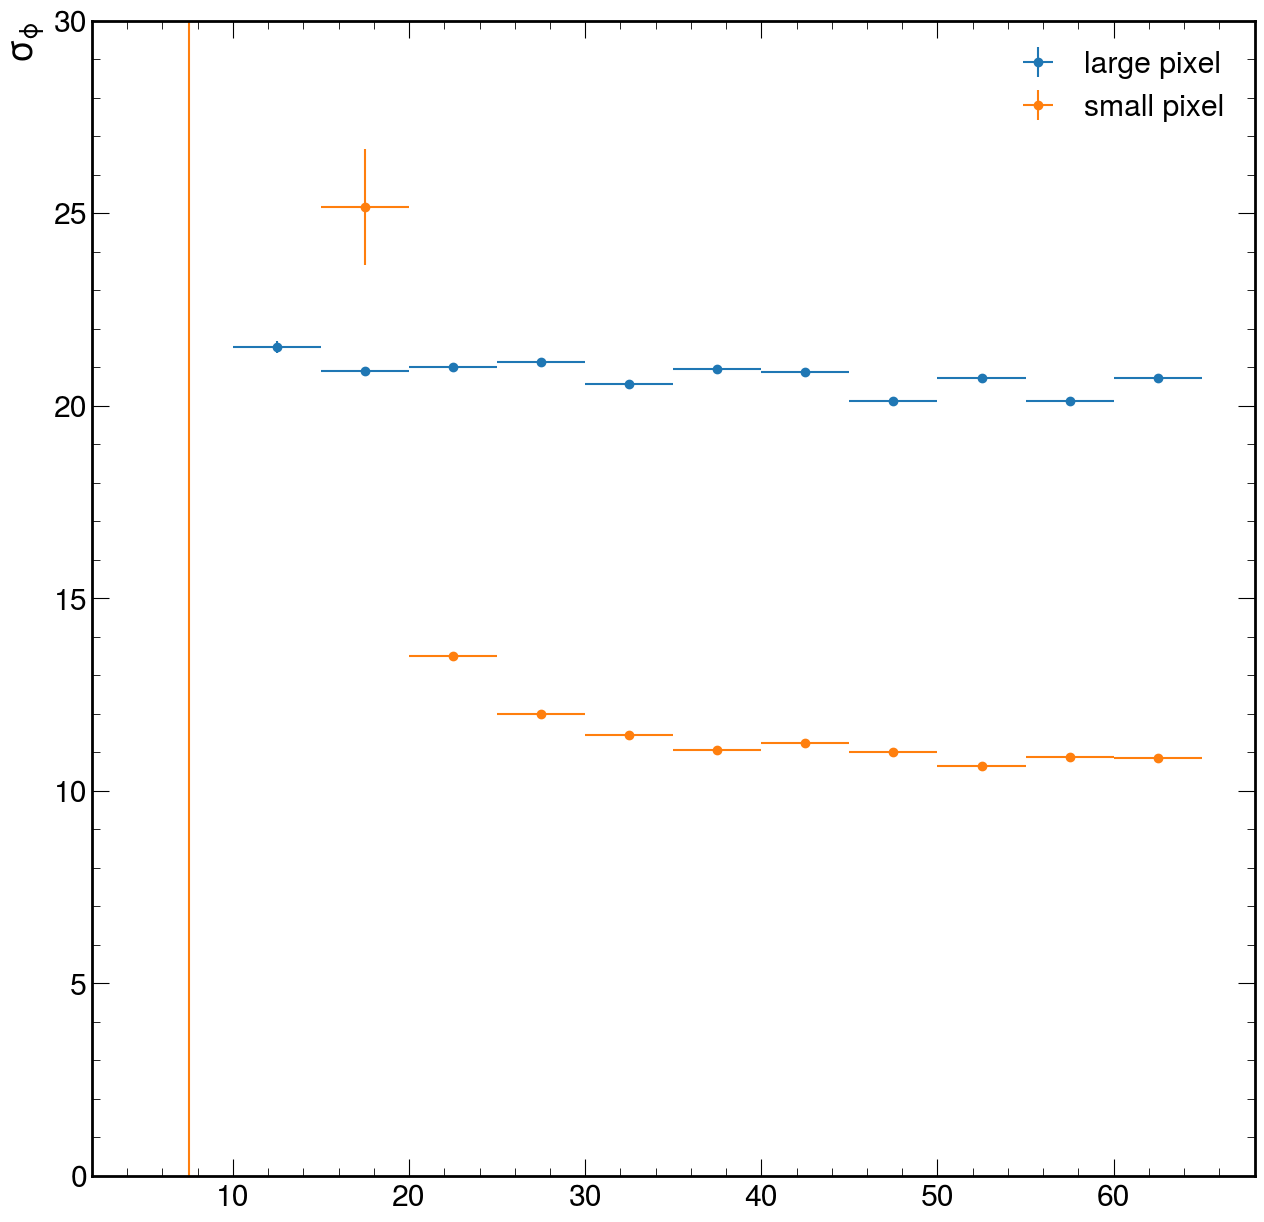

In [6]:
plt.figure(figsize=(15,15))
labels = ['large pixel','small pixel']
for j in range(2):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,2][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,yerr=error[j*12:(j+1)*12],label=f'{labels[j]}',fmt='o')
plt.ylabel(r'$\sigma_{\phi}$')
plt.ylim(bottom=0,top=30)
plt.legend()
plt.savefig('ThetaResolution_sigma.png',format='png')

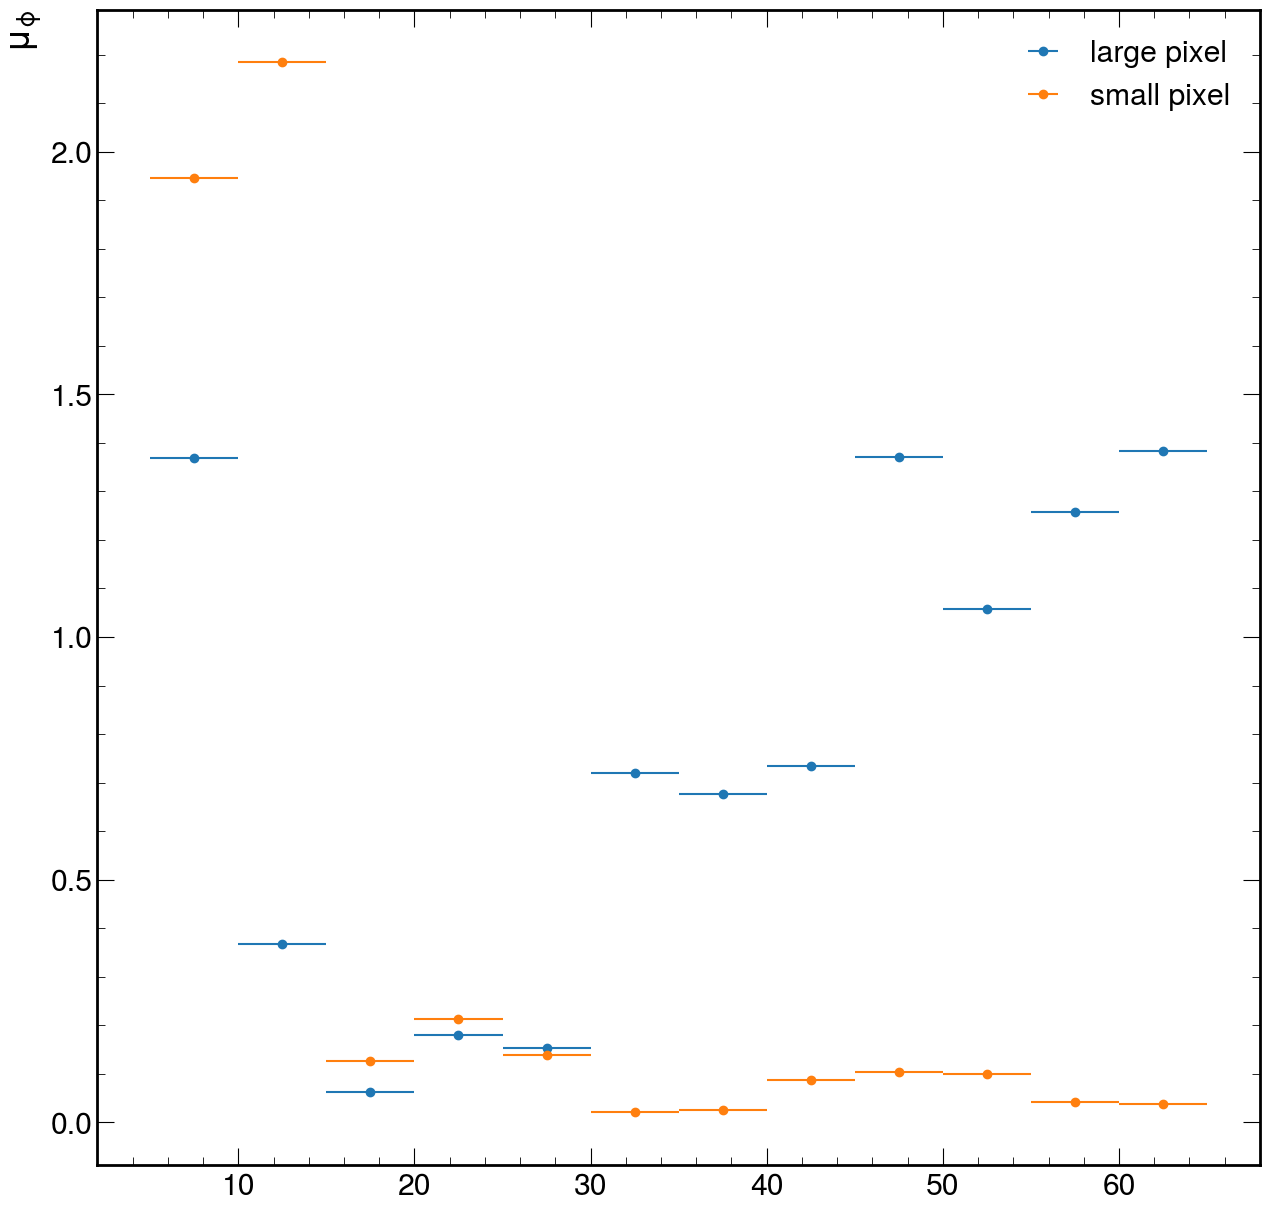

In [7]:
plt.figure(figsize=(15,15))
for j in range(2):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,1][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,label=f'{labels[j]}',fmt='o')

plt.ylabel(r'$\mu_{\phi}$')
#plt.ylim(bottom=0)
plt.legend()
plt.savefig('ThetaResolution_mu.png',format='png')

/tmp/ipykernel_728529/4219297291.py:30: RuntimeWarning: divide by zero encountered in divide
  coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100),sigma=1/np.sqrt(y))
/tmp/ipykernel_728529/4219297291.py:54: RuntimeWarning: divide by zero encountered in divide
  coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100),sigma=1/np.sqrt(y))


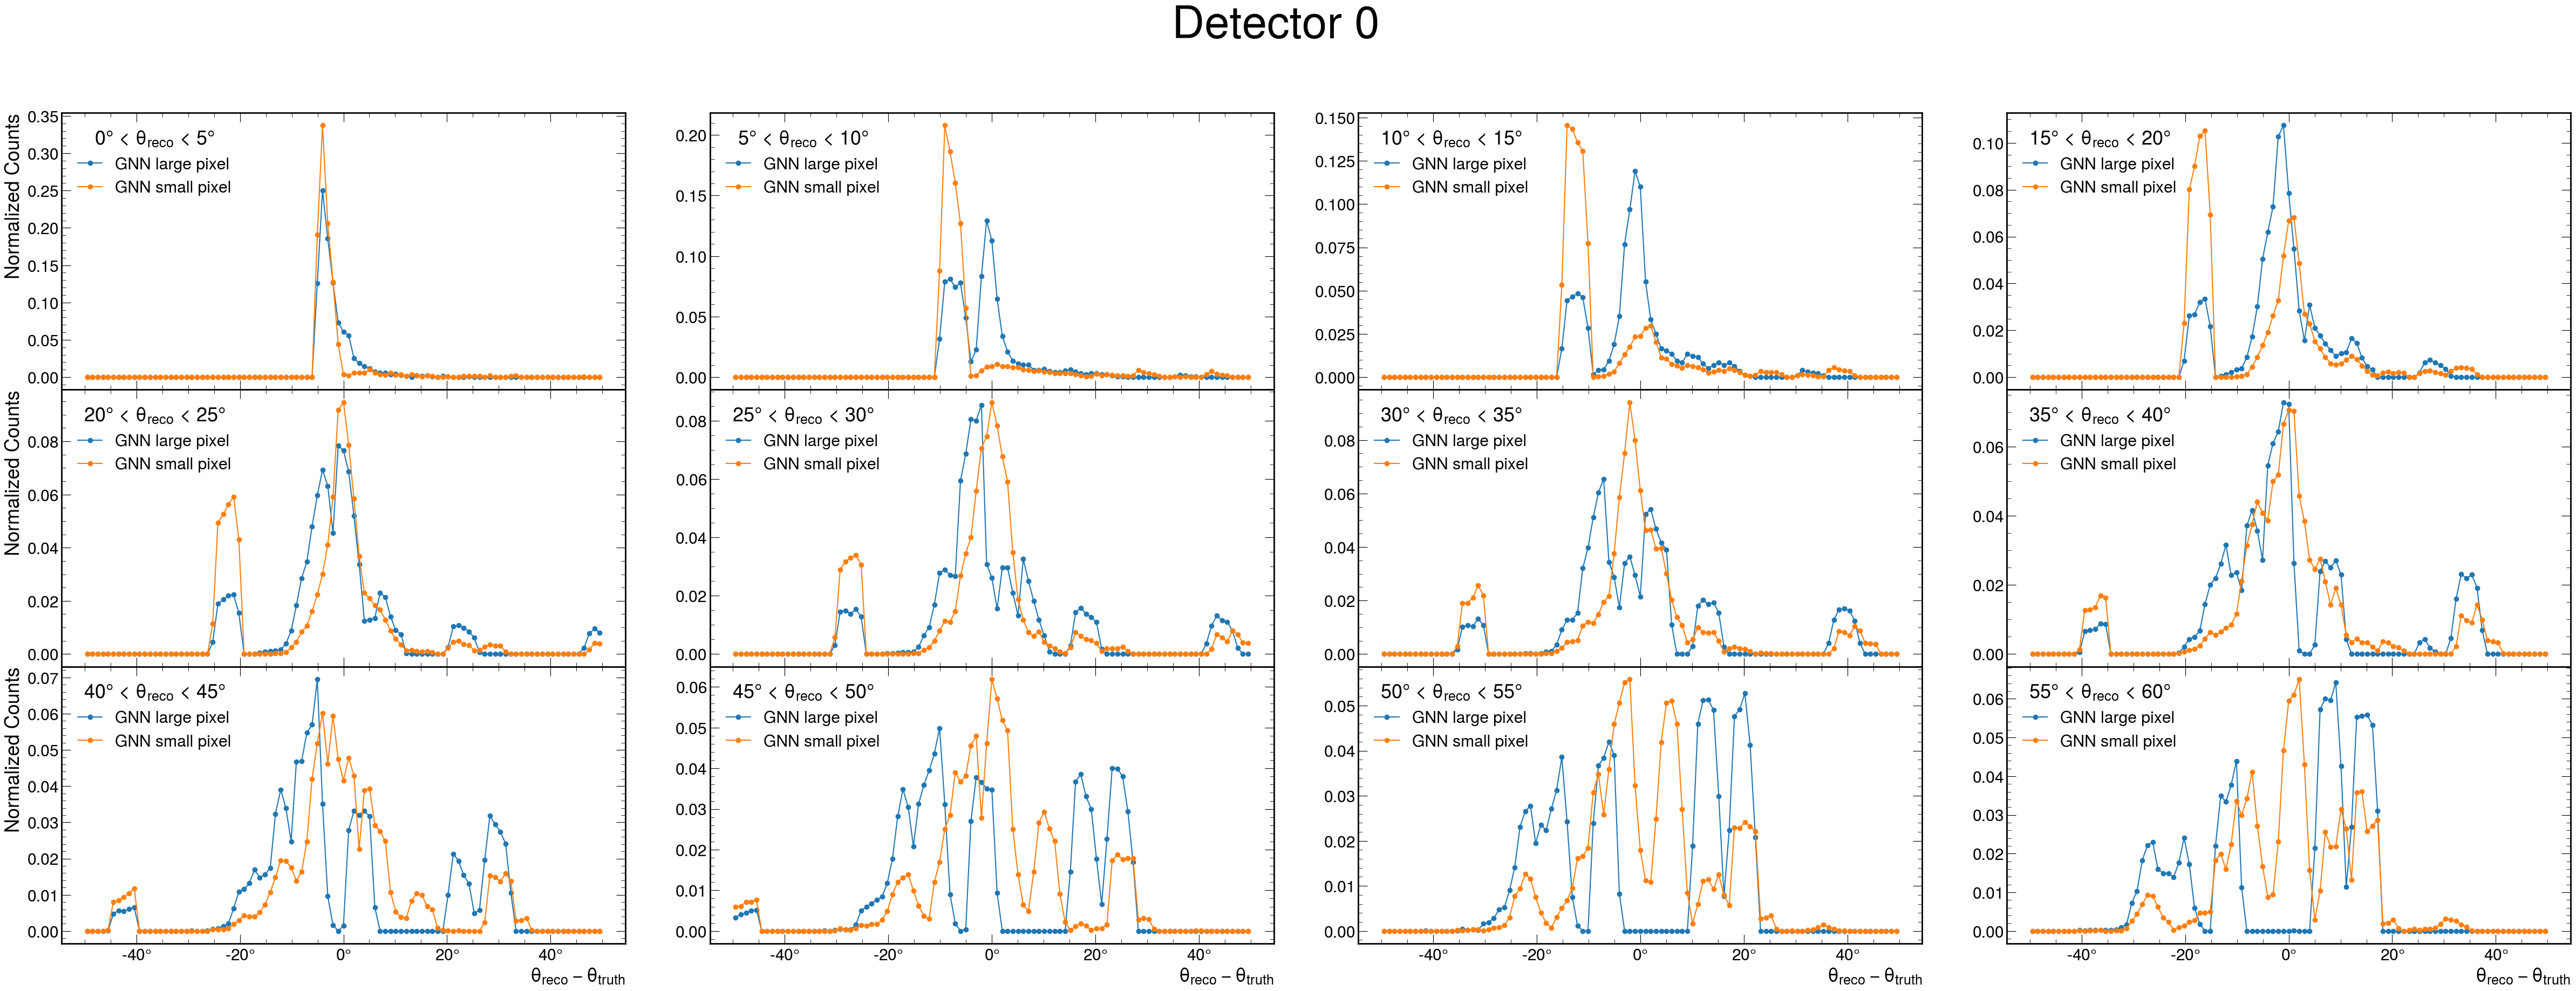

In [40]:
def theta_from_energy(E, A, k, C):
    return -(1.0 / k) * np.log((E - C) / A)
    
binsize = 5
bins= []
rms = []
mea = []
fits = []
error = []
det = []
binnum = np.linspace(-50,50,100)
max_bin = 65
for j in range(1):
    
    fig, ax = plt.subplots(3,4,figsize=(60,20),sharex=True,sharey=False)
        
    for i in range(12):
        plt.sca(ax[i//4,i%4])
        bins.append(i*binsize+5+binsize/2)
        detector_cut = df['detector']==j
        cut = (((i) * binsize <= df['theta_true'][detector_cut]) & (df['theta_true'][detector_cut] < (i+1) * binsize))

        y,x = np.histogram(df['theta_reco'][detector_cut][cut]-df['theta_true'][detector_cut][cut],bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='GNN large pixel')
        means = df['theta_reco'][detector_cut][cut]-df['theta_true'][detector_cut][cut]
        rms.append(np.std(means))
        mea.append(np.mean(means))
        try:
            coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100),sigma=1/np.sqrt(y))
            det.append(j)
            fits.append(coeff)
            error.append(covar[2][2])
            #plt.errorbar(x,gaus(x,*coeff),fmt='--')
        except: 
            det.append(j)
            fits.append([0,0,0])
            error.append(0)
        plt.xlabel(r'$\theta_{reco} - \theta_{truth}$')
        plt.legend(title=rf'{i * binsize}$\degree$ < $\theta_{{reco}}$ < {(i+1) * binsize}$\degree$', loc = 'upper left')

    for i in range(12):
        plt.sca(ax[i//4,i%4])
        detector_cut = dg['detector']==j
        cut = (((i) * binsize <= dg['theta_true'][detector_cut]) & (dg['theta_true'][detector_cut] < (i+1) * binsize))

        y,x = np.histogram(dg['theta_reco'][detector_cut][cut]-dg['theta_true'][detector_cut][cut],bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='GNN small pixel')
        means = dg['theta_reco'][detector_cut][cut]-dg['theta_true'][detector_cut][cut]
        rms.append(np.std(means))
        mea.append(np.mean(means))
        try:
            coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100),sigma=1/np.sqrt(y))
            det.append(j)
            fits.append(coeff)
            error.append(covar[2][2])
            #plt.errorbar(x,gaus(x,*coeff),fmt='--')
        except: 
            det.append(j)
            fits.append([0,0,0])
            error.append(0)
        plt.xlabel(r'$\theta_{reco} - \theta_{truth}$')
        plt.legend(title=rf'{i * binsize}$\degree$ < $\theta_{{reco}}$ < {(i+1) * binsize}$\degree$', loc = 'upper left')
        
        #plt.xlim(-50,50)
    fig.subplots_adjust(wspace=0.15,hspace=0)
    
    ax[0,0].set_ylabel('Normalized Counts')
    ax[1,0].set_ylabel('Normalized Counts')
    ax[2,0].set_ylabel('Normalized Counts')
    
    import matplotlib.ticker as mticker
    def degree_formatter(x, pos):
        return rf"{int(x)}$\degree$" 
    for axi in ax.flat:
        axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))
    
    plt.savefig('ThetaResolution_differential.pdf',format='pdf')
    plt.suptitle(f'Detector {j}', fontsize=60)
    plt.show()

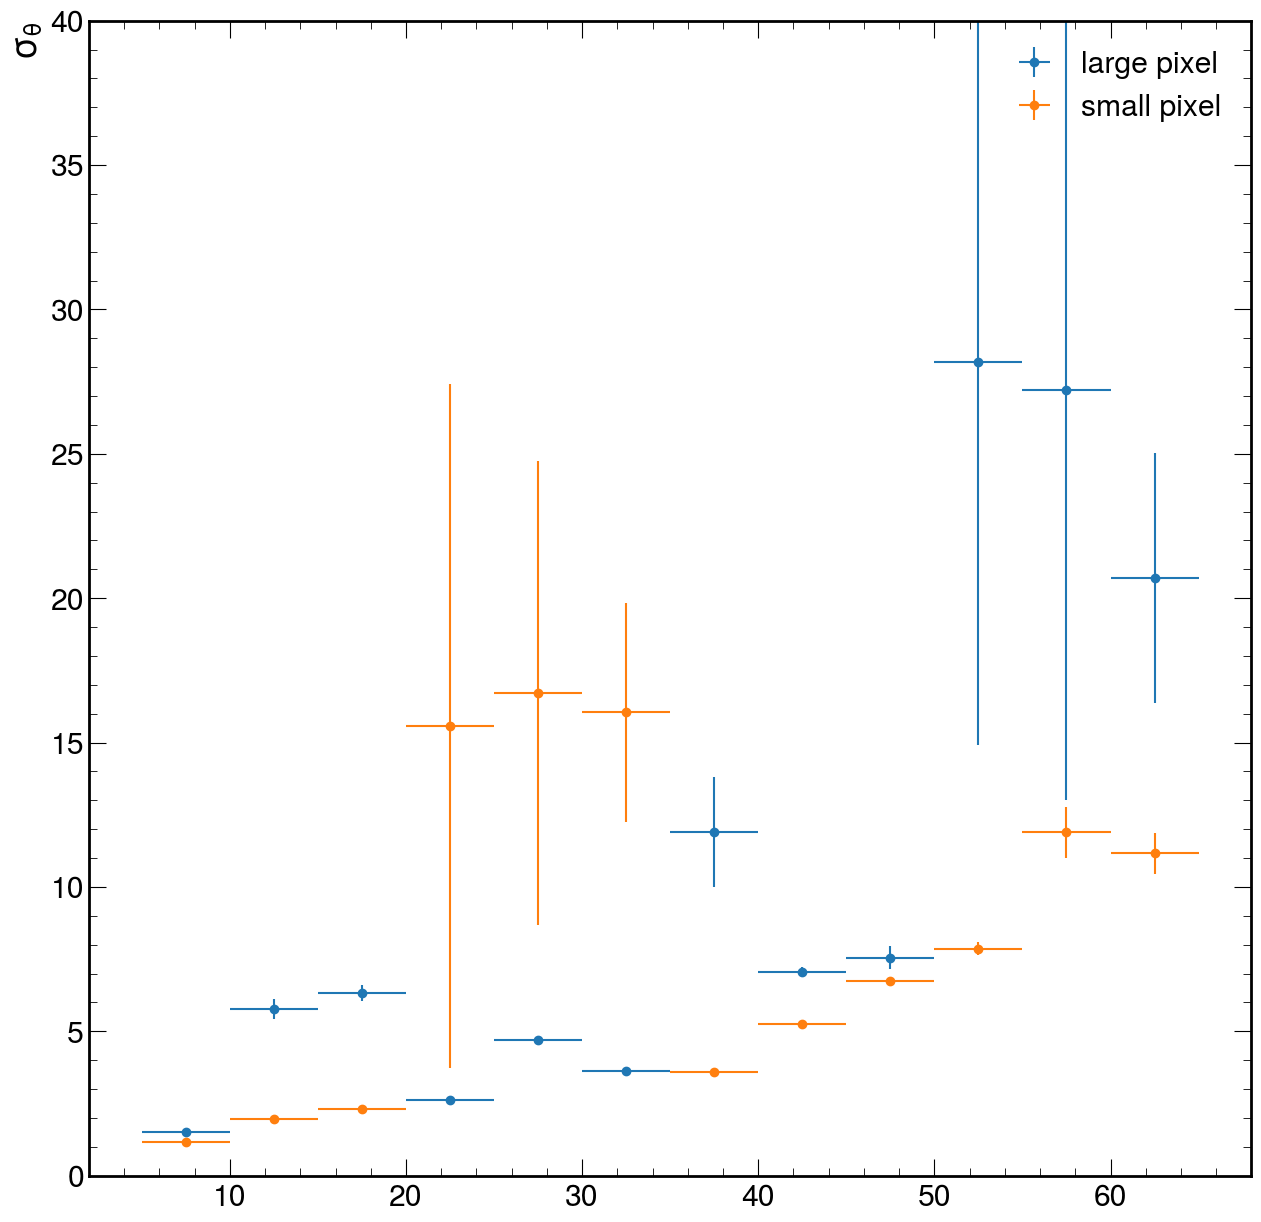

In [41]:
plt.figure(figsize=(15,15))
labels = ['large pixel','small pixel']
for j in range(2):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,2][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,yerr=error[j*12:(j+1)*12],label=f'{labels[j]}',fmt='o')
plt.ylabel(r'$\sigma_{\theta}$')
plt.ylim(bottom=0,top=40)
plt.legend()
plt.savefig('ThetaResolution_sigma.png',format='png')

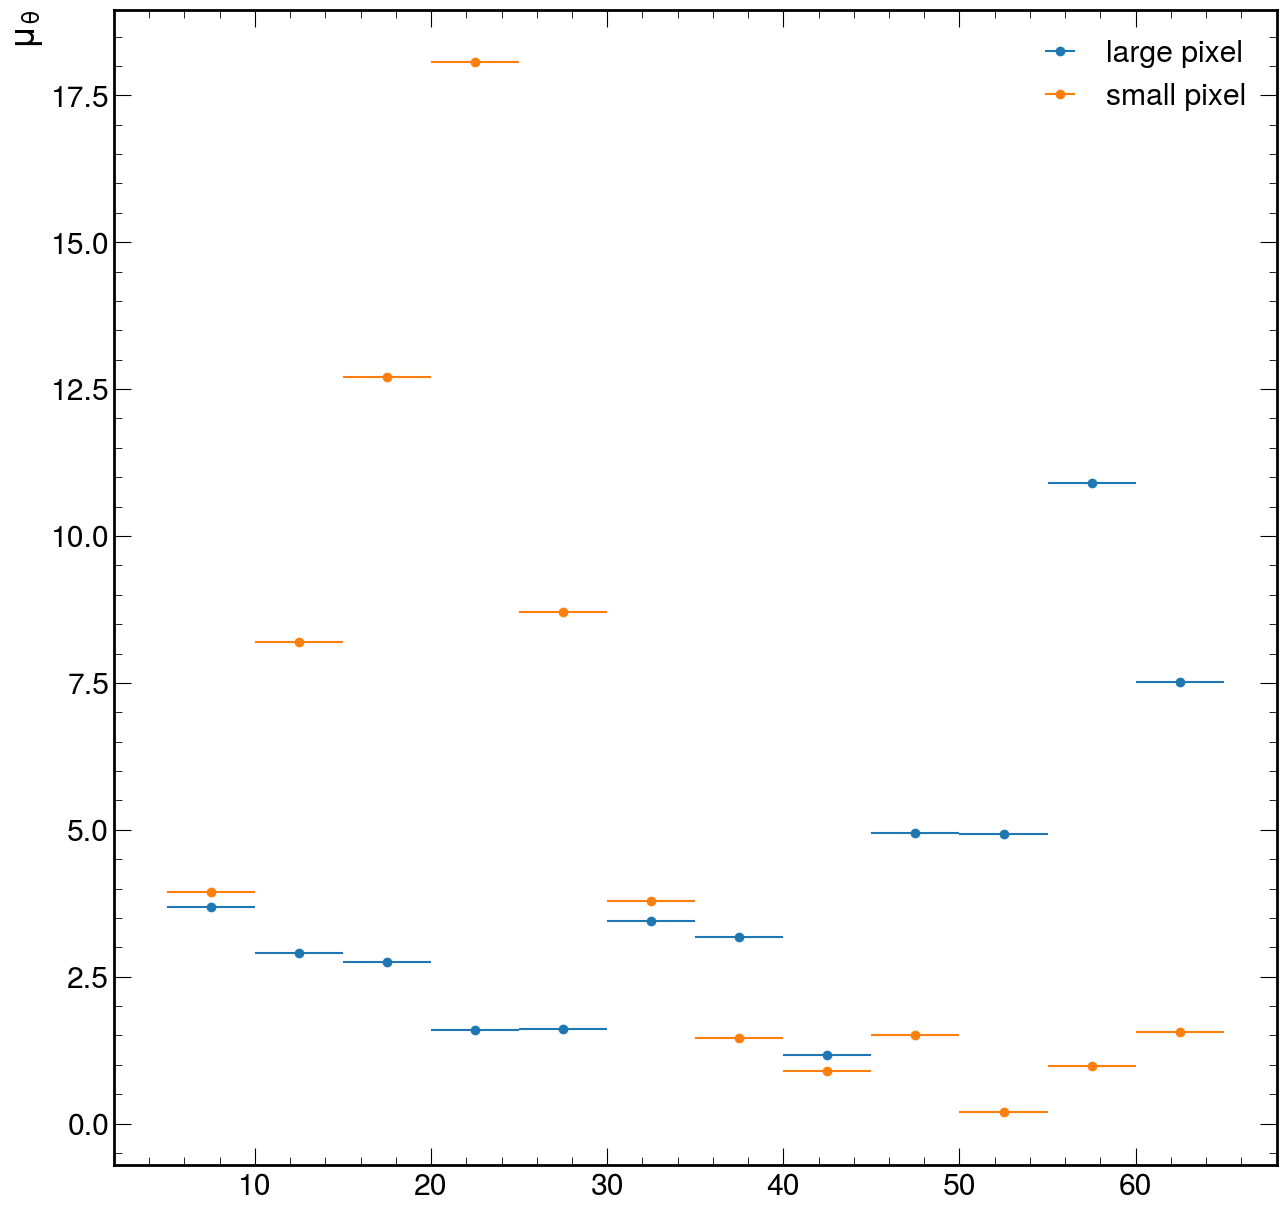

In [42]:
plt.figure(figsize=(15,15))
for j in range(2):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,1][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,label=f'{labels[j]}',fmt='o')

plt.ylabel(r'$\mu_{\theta}$')
#plt.ylim(bottom=0)
plt.legend()
plt.savefig('ThetaResolution_mu.png',format='png')

In [11]:
num = []
num1 = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    num.append(len(df['detector'][df['detector']==i]))
    num1.append(len(dg['detector'][dg['detector']==i]))

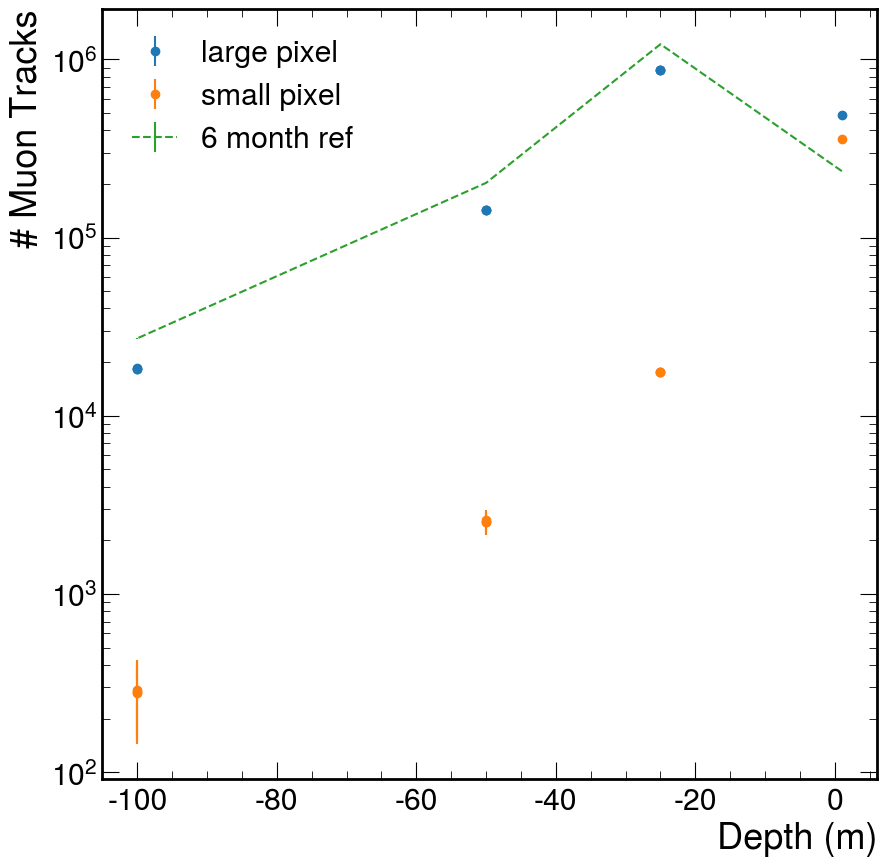

In [12]:
plt.errorbar([1,-25,-50,-100,-25,-50,-100,-25,-50,-100],num,yerr=np.sqrt(num),fmt='o',label=labels[0])
plt.errorbar([1,-25,-50,-100,-25,-50,-100,-25,-50,-100],np.array(num1),yerr=np.sqrt(num),fmt='o',label=labels[1])
plt.errorbar([1,-25,-50,-100],[235874, 1216686, 202712, 27192],yerr=np.sqrt([235874, 1216686, 202712, 27192]),fmt='--',label='6 month ref')
plt.xlabel('Depth (m)')
plt.ylabel('# Muon Tracks')
plt.yscale('log')
plt.legend()

In [13]:
arrays['large']

<Array [{'MCParticles.PDG': [...], ...}, ...] type='1000001 * {"MCParticles...'>

Text(0, 1, 'Cell Hits')

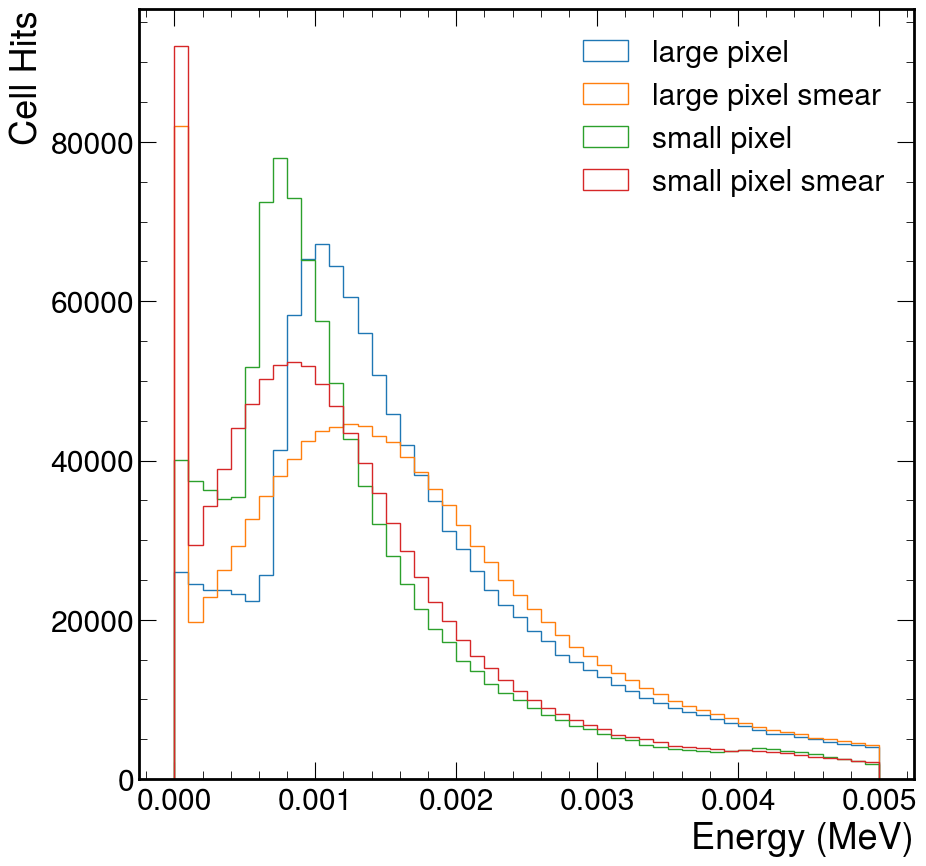

In [14]:
labels = ['large','small']
for label in labels:
    y,x=np.histogram(ak.flatten(arrays[label]["MuographyHits.energy"]), bins=100, range=(0, 0.004))
    bc=(x[1:]+x[:-1])/2
    MIP=list(bc[y==max(y[3:])])[0] 
    # plt.errorbar(np.array(bc)*1000,np.array(y),yerr=np.sqrt(y))
    # plt.axvline(0.2*MIP*1000,label=f'MIP = {MIP*1000:.2f} MeV')
    # plt.xlabel('Cell Energy (MeV)')
    # plt.legend()
    # plt.show()
    
    data_energy = arrays[label][f'MuographyHits.energy']
    
    sigma = 0.56
    
    # flatten to numpy
    flat = ak.to_numpy(data_energy.layout.content)
    noise = np.random.normal(0, sigma, size=len(flat))*MIP
    
    # add noise
    flat_smear = np.clip(flat + noise, a_min=1e-16, a_max=None)
    
    offsets = ak.to_numpy(data_energy.layout.offsets)  # convert Index64 → numpy
    lengths = offsets[1:] - offsets[:-1]
    data_energy_smear = ak.unflatten(flat_smear, lengths)
    #plt.axvline(MIP*0.2)
    plt.hist(ak.flatten(arrays[label]["MuographyHits.energy"]),bins=50,range=(0,0.005),histtype='step',label=label+' pixel')
    plt.hist(ak.flatten(data_energy_smear),bins=50,range=(0,0.005),histtype='step',label=label+' pixel smear')

plt.legend()
plt.xlabel('Energy (MeV)')
plt.ylabel('Cell Hits')

In [45]:
path_to_result = "/home/jiajun/muography/data/nine_v5/split/training/model"
# Will likely need to change name of npz file for your use case
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz", allow_pickle=True) 

predictions_unnormalized = npz_unpacked['outputs_scaled'].item()
targets_unnormalized = npz_unpacked['targets_scaled'].item()
predictions = npz_unpacked['outputs'].item()
targets = npz_unpacked['targets'].item()
meta = npz_unpacked['meta']

truth_large = np.degrees(targets_unnormalized["theta"])
targets_phi_large = np.degrees(targets_unnormalized["phi"])
gnn_large = np.degrees(predictions_unnormalized["theta"])
predictions_phi_large = np.degrees(predictions_unnormalized["phi"])

In [46]:
path_to_result = "/home/jiajun/muography/data/nine_v5_1/split/training/model/"
# Will likely need to change name of npz file for your use case
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz", allow_pickle=True) 

predictions_unnormalized = npz_unpacked['outputs_scaled'].item()
targets_unnormalized = npz_unpacked['targets_scaled'].item()
predictions = npz_unpacked['outputs'].item()
targets = npz_unpacked['targets'].item()
meta = npz_unpacked['meta']

truth_small = np.degrees(targets_unnormalized["theta"])
targets_phi_small = np.degrees(targets_unnormalized["phi"])
gnn_small = np.degrees(predictions_unnormalized["theta"])
predictions_phi_small = np.degrees(predictions_unnormalized["phi"])

/tmp/ipykernel_728529/119515344.py:28: RuntimeWarning: divide by zero encountered in divide
  coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.01,0,20),sigma=1/y)
/tmp/ipykernel_728529/119515344.py:46: RuntimeWarning: divide by zero encountered in divide
  coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.01,0,20),sigma=1/y)


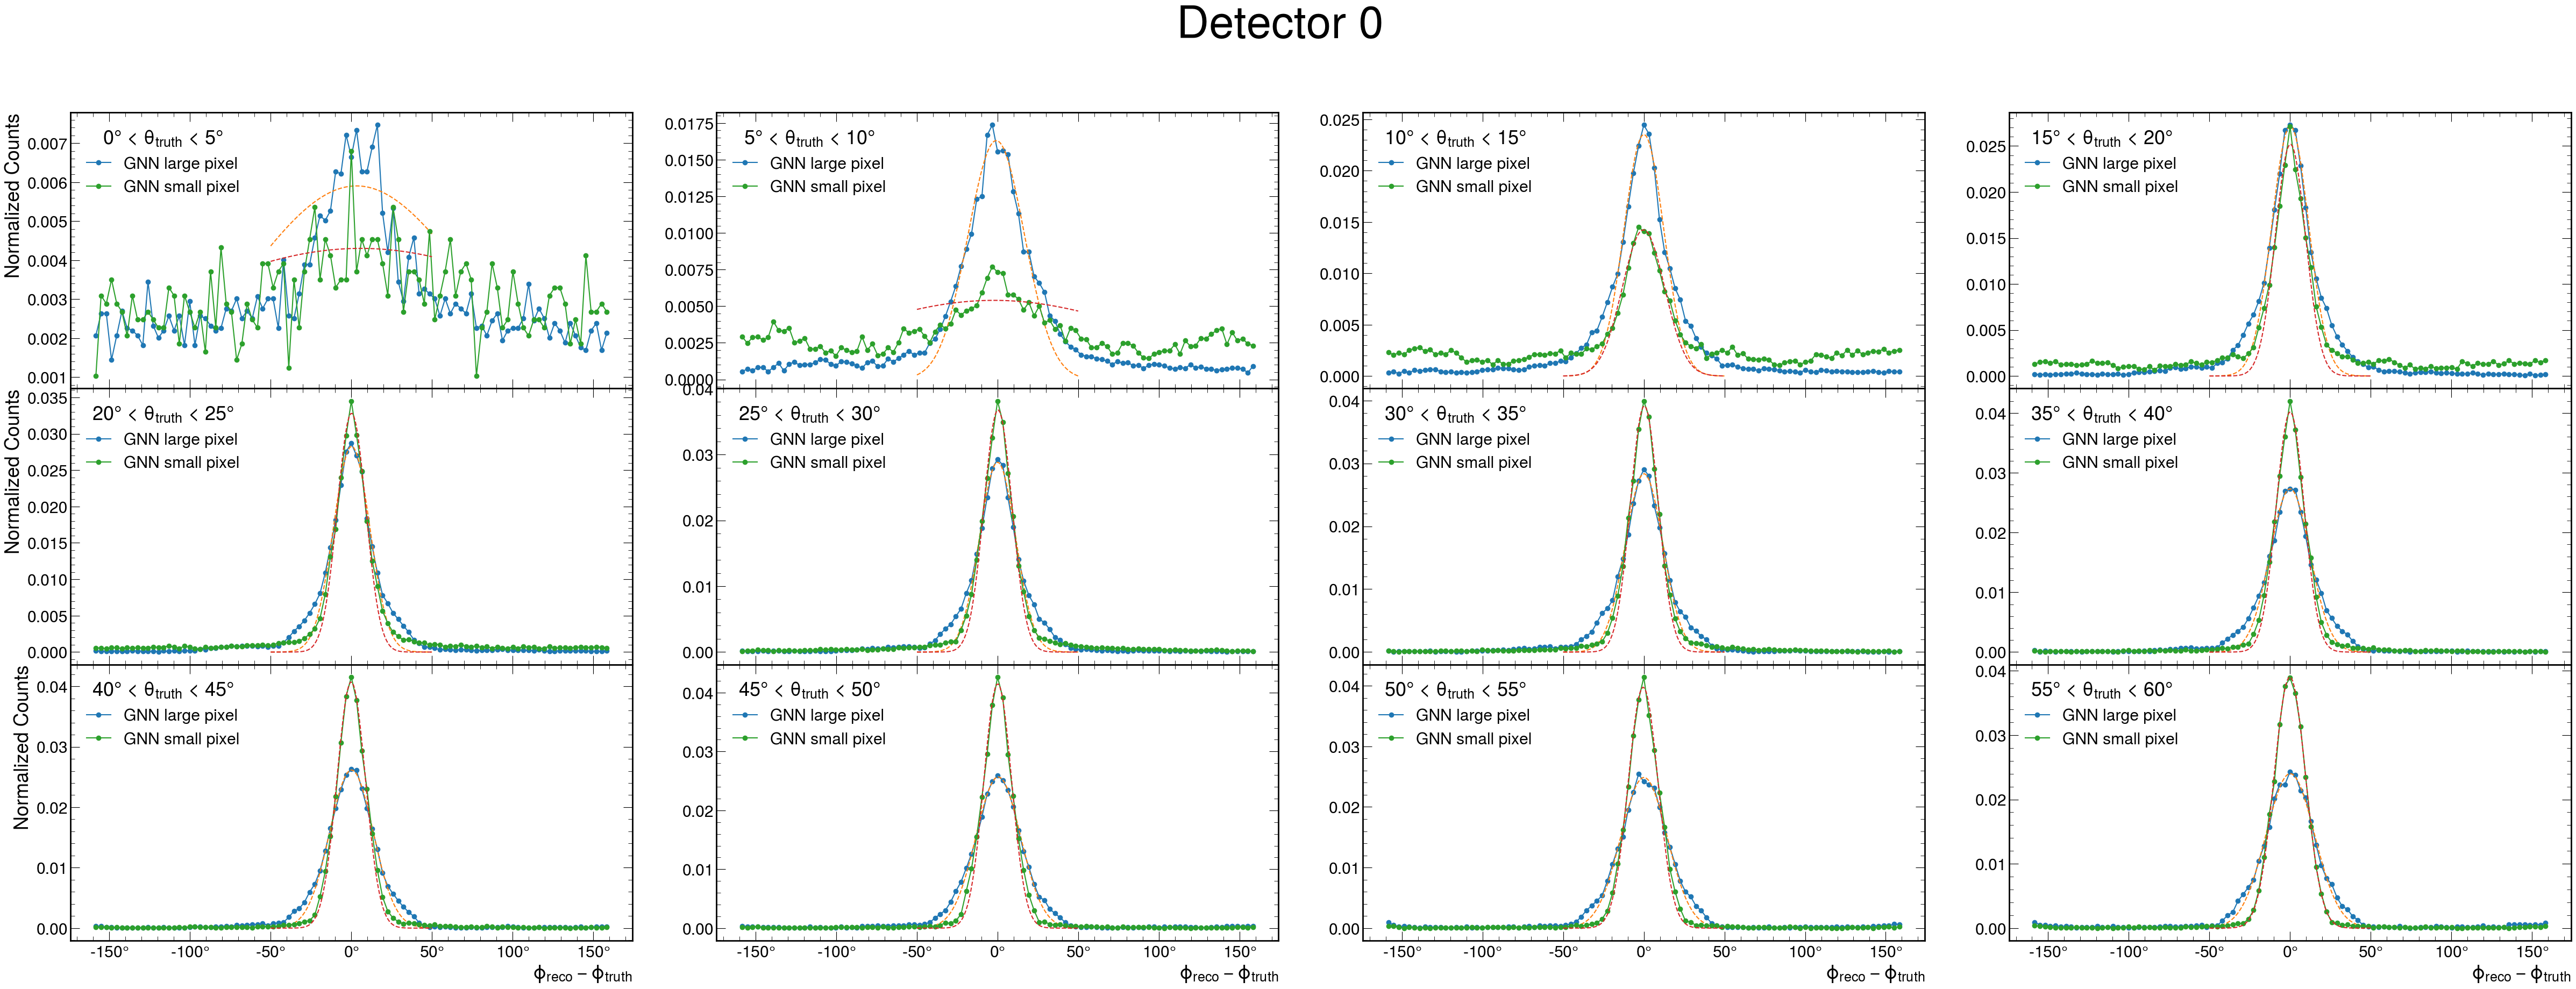

In [50]:
def theta_from_energy(E, A, k, C):
    return -(1.0 / k) * np.log((E - C) / A)
    
binsize = 5
bins= []
rms = []
mea = []
fits = []
error = []
binnum = np.linspace(-160,160,100)
max_bin = 65
for j in range(1):
    fig, ax = plt.subplots(3,4,figsize=(60,20),sharex=True,sharey=False)

    for i in range(12):
        plt.sca(ax[i//4,i%4])
        bins.append(i*binsize+5+binsize/2)
        cut = (((i) * binsize <= truth_large) & (truth_large < (i+1) * binsize))

        means = predictions_phi_large[cut]-targets_phi_large[cut]
        y,x = np.histogram(means,bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='GNN large pixel')
        
        rms.append(np.std(means))
        mea.append(np.mean(means))
        
        coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.01,0,20),sigma=1/y)
        fits.append(coeff)
        error.append(covar[2][2])
        x=np.linspace(-50,50,100)
        plt.errorbar(x,gaus(x,*coeff),fmt='--')
        
    for i in range(12):
        plt.sca(ax[i//4,i%4])
        cut = (((i) * binsize <= truth_small) & (truth_small < (i+1) * binsize))

        means = predictions_phi_small[cut]-targets_phi_small[cut]
        y,x = np.histogram(means,bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='GNN small pixel')
        
        rms.append(np.std(means))
        mea.append(np.mean(means))
        
        coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.01,0,20),sigma=1/y)
        fits.append(coeff)
        error.append(covar[2][2])
        x=np.linspace(-50,50,100)
        plt.errorbar(x,gaus(x,*coeff),fmt='--')
        
        plt.xlabel(r'$\phi_{reco} - \phi_{truth}$')
        plt.legend(title=rf'{i * binsize}$\degree$ < $\theta_{{truth}}$ < {(i+1) * binsize}$\degree$', loc = 'upper left')
        #plt.xlim(-50,50)
    fig.subplots_adjust(wspace=0.15,hspace=0)
    
    ax[0,0].set_ylabel('Normalized Counts')
    ax[1,0].set_ylabel('Normalized Counts')
    ax[2,0].set_ylabel('Normalized Counts')
    
    import matplotlib.ticker as mticker
    def degree_formatter(x, pos):
        return rf"{int(x)}$\degree$" 
    for axi in ax.flat:
        axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))
    
    #plt.savefig('ThetaResolution_differential.pdf',format='pdf')
    plt.suptitle(f'Detector {j}', fontsize=60)
    plt.show()

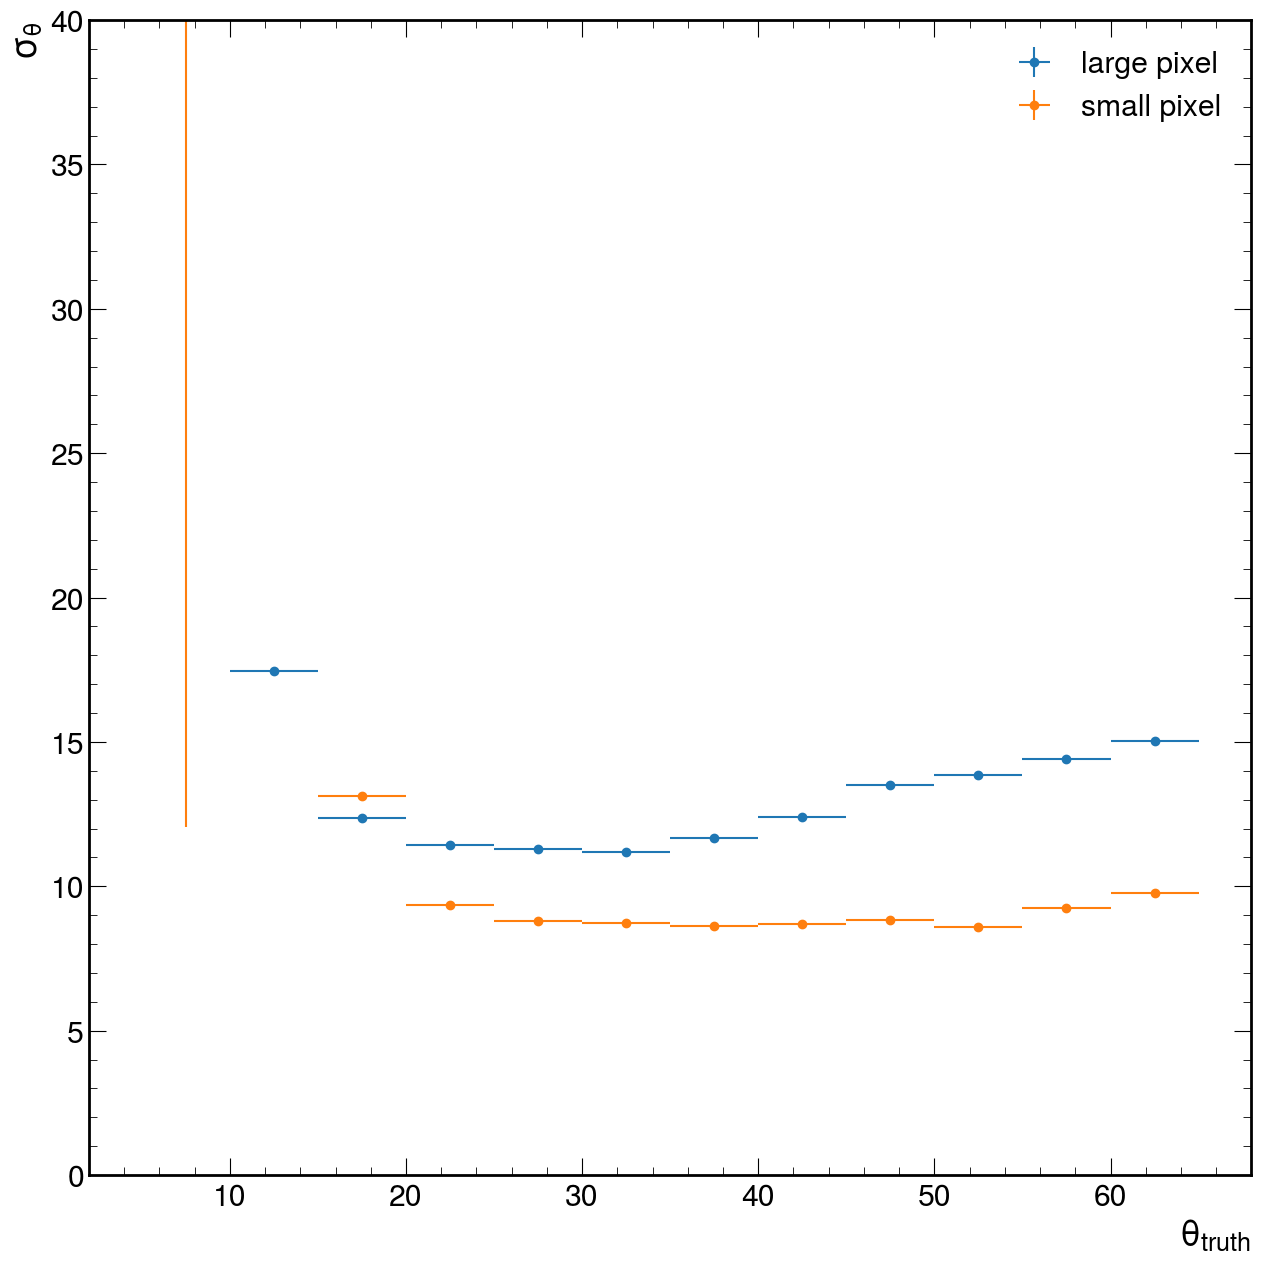

In [51]:
plt.figure(figsize=(15,15))
labels = ['large pixel','small pixel']
for j in range(2):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,2][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,yerr=error[j*12:(j+1)*12],label=f'{labels[j]}',fmt='o')
plt.ylabel(r'$\sigma_{\theta}$')
plt.xlabel(r'$\theta_{truth}$')
plt.ylim(bottom=0,top=40)
plt.legend()
plt.savefig('ThetaResolution_sigma.png',format='png')

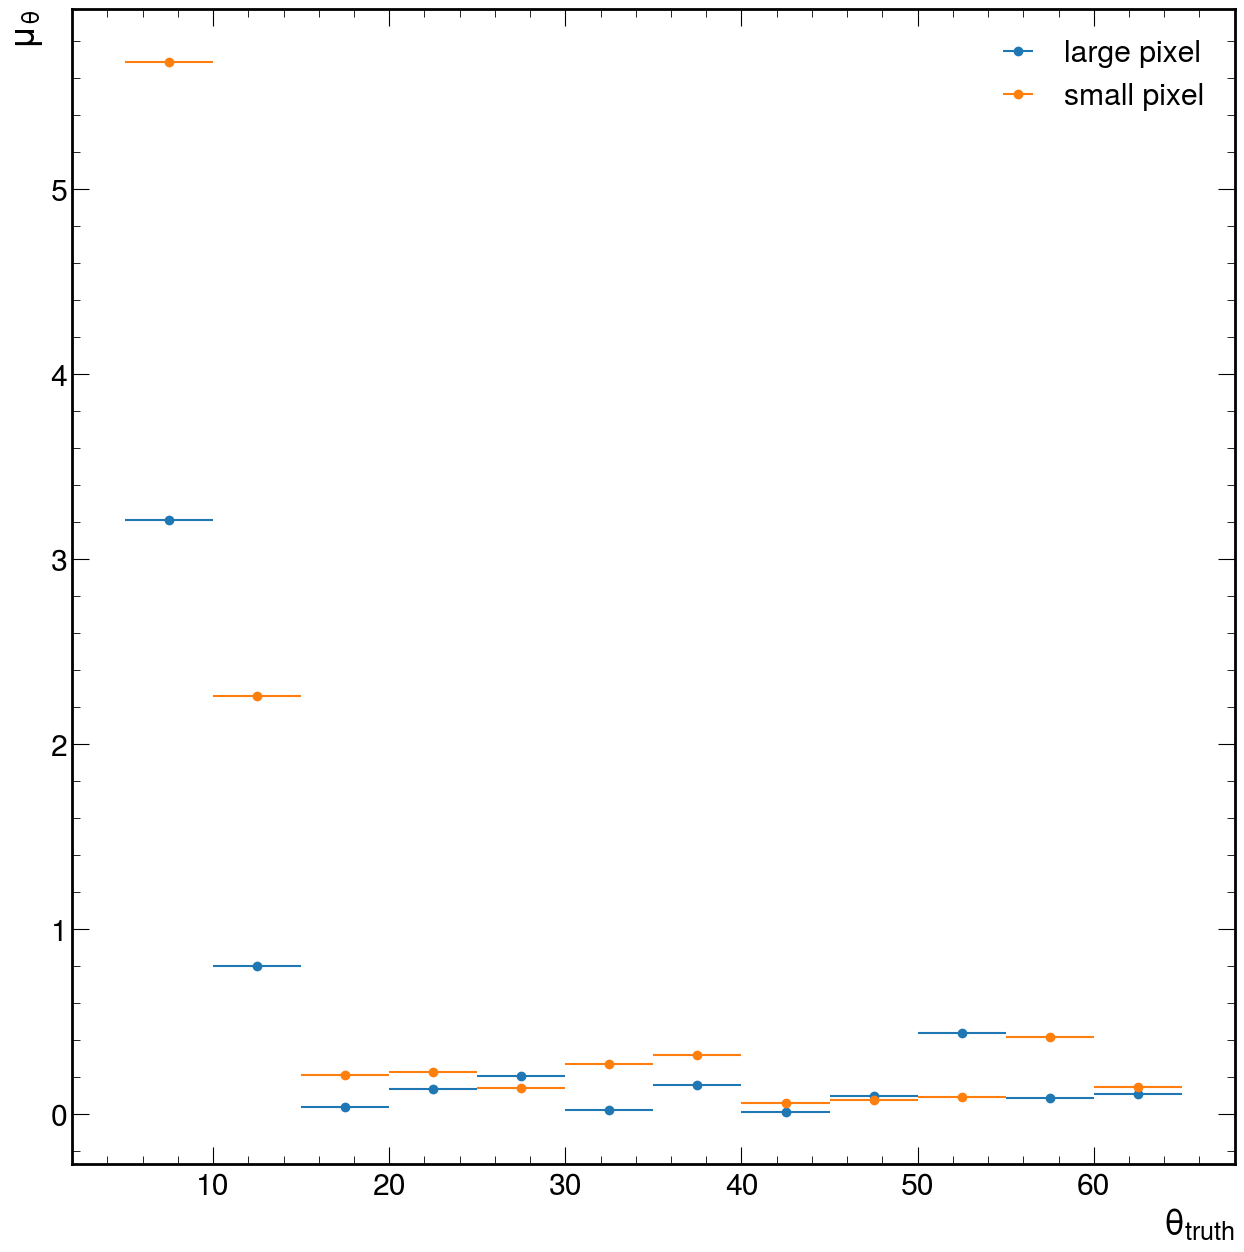

In [52]:
plt.figure(figsize=(15,15))
for j in range(2):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,1][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,label=f'{labels[j]}',fmt='o')

plt.ylabel(r'$\mu_{\theta}$')
plt.xlabel(r'$\theta_{truth}$')

#plt.ylim(bottom=0)
plt.legend()
plt.savefig('ThetaResolution_mu.png',format='png')

/tmp/ipykernel_728529/4165551465.py:29: RuntimeWarning: divide by zero encountered in divide
  coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100),sigma=1/np.sqrt(y))
/tmp/ipykernel_728529/4165551465.py:52: RuntimeWarning: divide by zero encountered in divide
  coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100),sigma=1/np.sqrt(y))


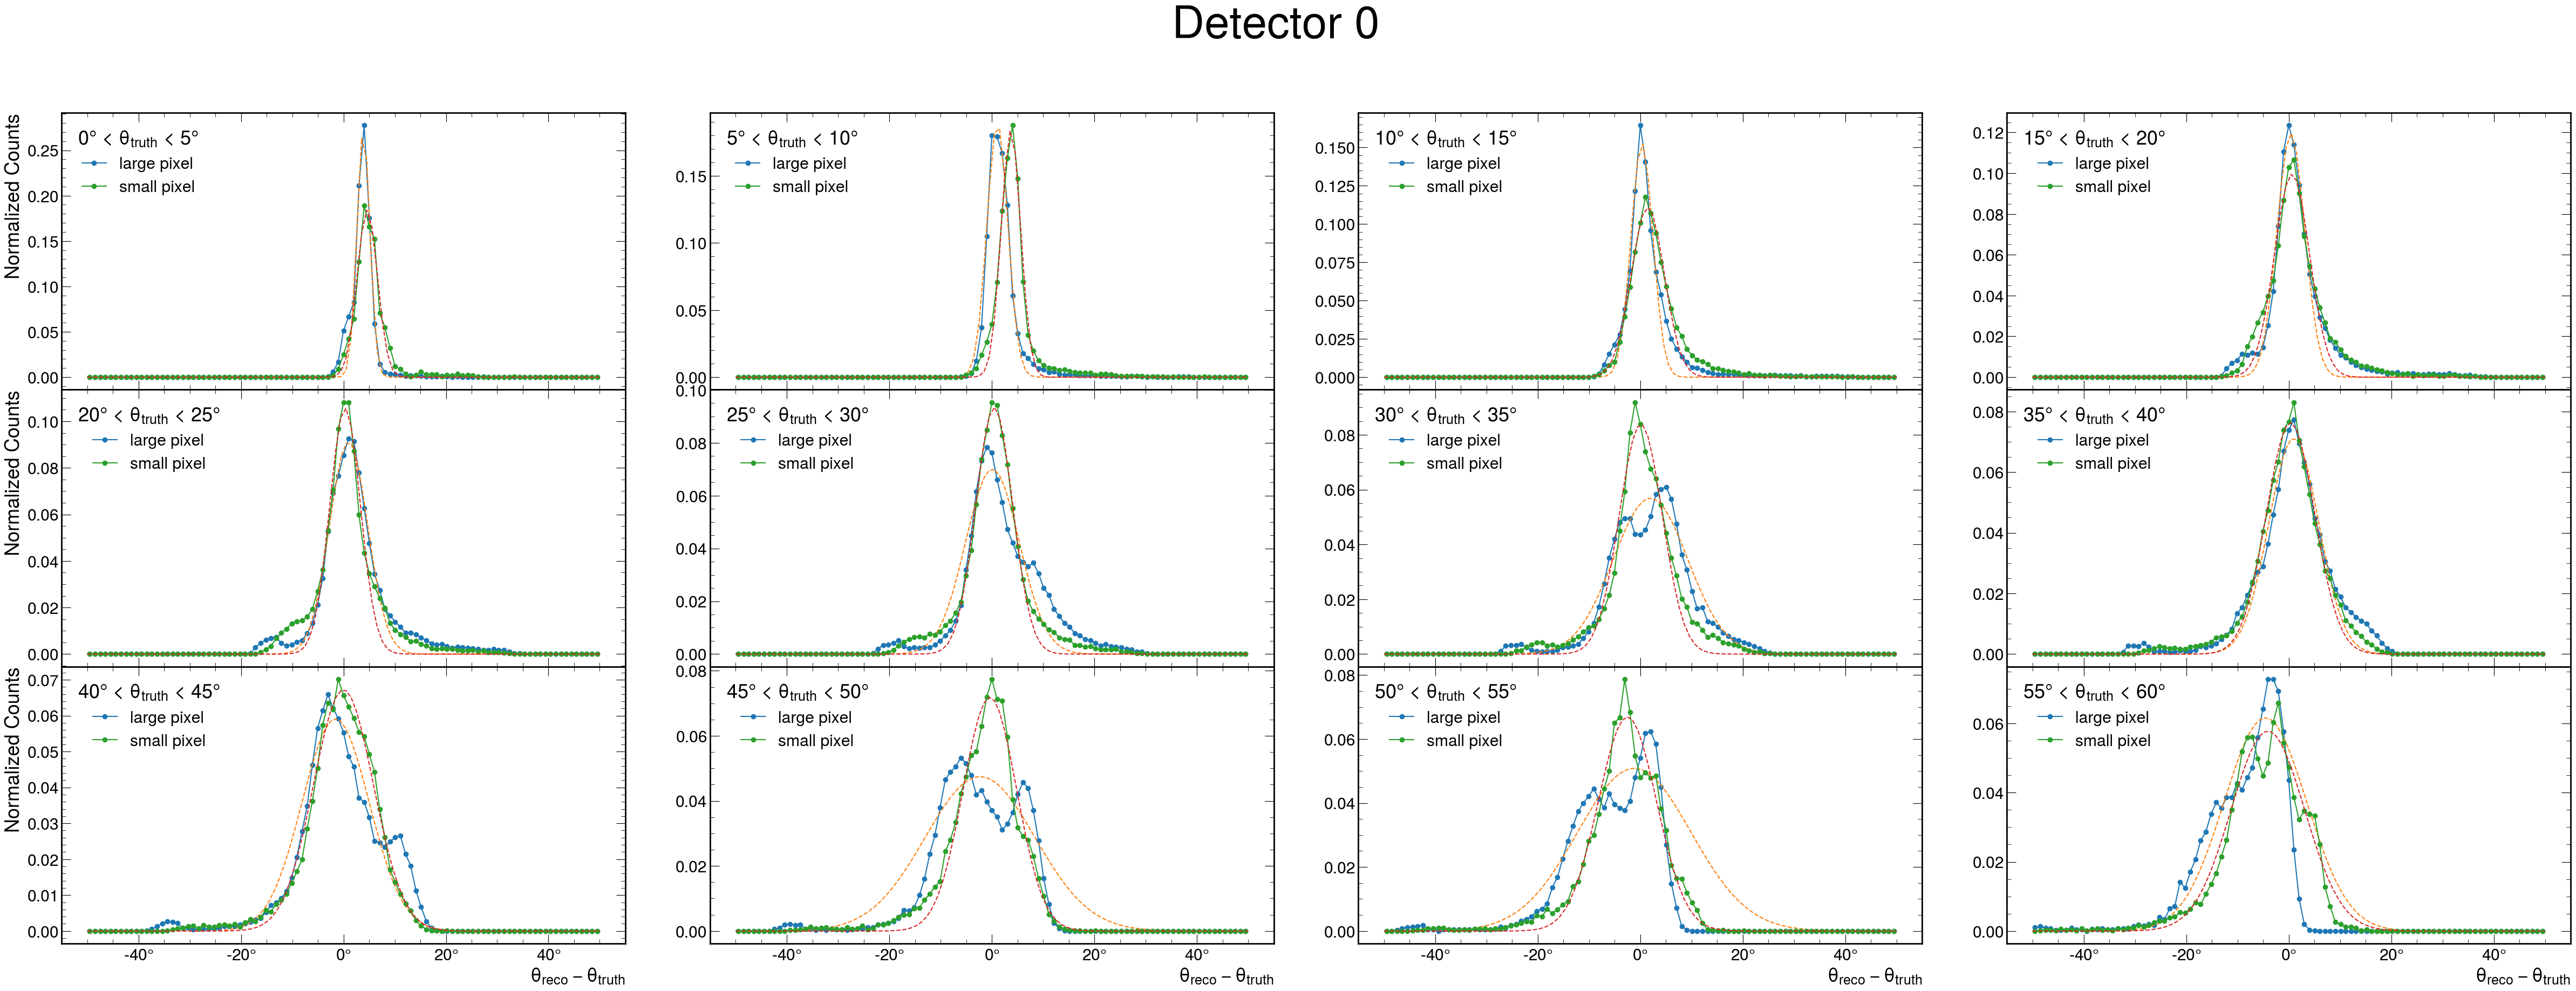

In [53]:
def theta_from_energy(E, A, k, C):
    return -(1.0 / k) * np.log((E - C) / A)
    
binsize = 5
bins= []
rms = []
mea = []
fits = []
error = []
det = []
binnum = np.linspace(-50,50,100)
max_bin = 65
for j in range(1):
    
    fig, ax = plt.subplots(3,4,figsize=(60,20),sharex=True,sharey=False)
        
    for i in range(12):
        plt.sca(ax[i//4,i%4])
        bins.append(i*binsize+5+binsize/2)
        cut = (((i) * binsize <= truth_large) & (truth_large < (i+1) * binsize))
        means = gnn_large[cut]-truth_large[cut]
        y,x = np.histogram(means,bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='large pixel')
        
        rms.append(np.std(means))
        mea.append(np.mean(means))
        try:
            coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100),sigma=1/np.sqrt(y))
            det.append(j)
            fits.append(coeff)
            error.append(covar[2][2])
            plt.errorbar(x,gaus(x,*coeff),fmt='--')
        except: 
            det.append(j)
            fits.append([0,0,0])
            error.append(0)
        plt.xlabel(r'$\theta_{reco} - \theta_{truth}$')
        plt.legend(title=rf'{i * binsize}$\degree$ < $\theta_{{reco}}$ < {(i+1) * binsize}$\degree$', loc = 'upper left')

    for i in range(12):
        plt.sca(ax[i//4,i%4])
        cut = (((i) * binsize <= truth_small) & (truth_small < (i+1) * binsize))
        means = gnn_small[cut]-truth_small[cut]
        y,x = np.histogram(means,bins=binnum,density=True)
        bc=(x[1:]+x[:-1])/2
        plt.errorbar(bc,y, fmt='-o',label='small pixel')
        
        rms.append(np.std(means))
        mea.append(np.mean(means))
        try:
            coeff, covar = curve_fit(gaus,np.array(bc),np.array(y),p0=(0.1,0,100),sigma=1/np.sqrt(y))
            det.append(j)
            fits.append(coeff)
            error.append(covar[2][2])
            plt.errorbar(x,gaus(x,*coeff),fmt='--')
        except: 
            det.append(j)
            fits.append([0,0,0])
            error.append(0)
        plt.xlabel(r'$\theta_{reco} - \theta_{truth}$')
        plt.legend(title=rf'{i * binsize}$\degree$ < $\theta_{{truth}}$ < {(i+1) * binsize}$\degree$', loc = 'upper left')
        
        #plt.xlim(-50,50)
    fig.subplots_adjust(wspace=0.15,hspace=0)
    
    ax[0,0].set_ylabel('Normalized Counts')
    ax[1,0].set_ylabel('Normalized Counts')
    ax[2,0].set_ylabel('Normalized Counts')
    
    import matplotlib.ticker as mticker
    def degree_formatter(x, pos):
        return rf"{int(x)}$\degree$" 
    for axi in ax.flat:
        axi.xaxis.set_major_formatter(mticker.FuncFormatter(degree_formatter))
    
    plt.savefig('ThetaResolution_differential.pdf',format='pdf')
    plt.suptitle(f'Detector {j}', fontsize=60)
    plt.show()

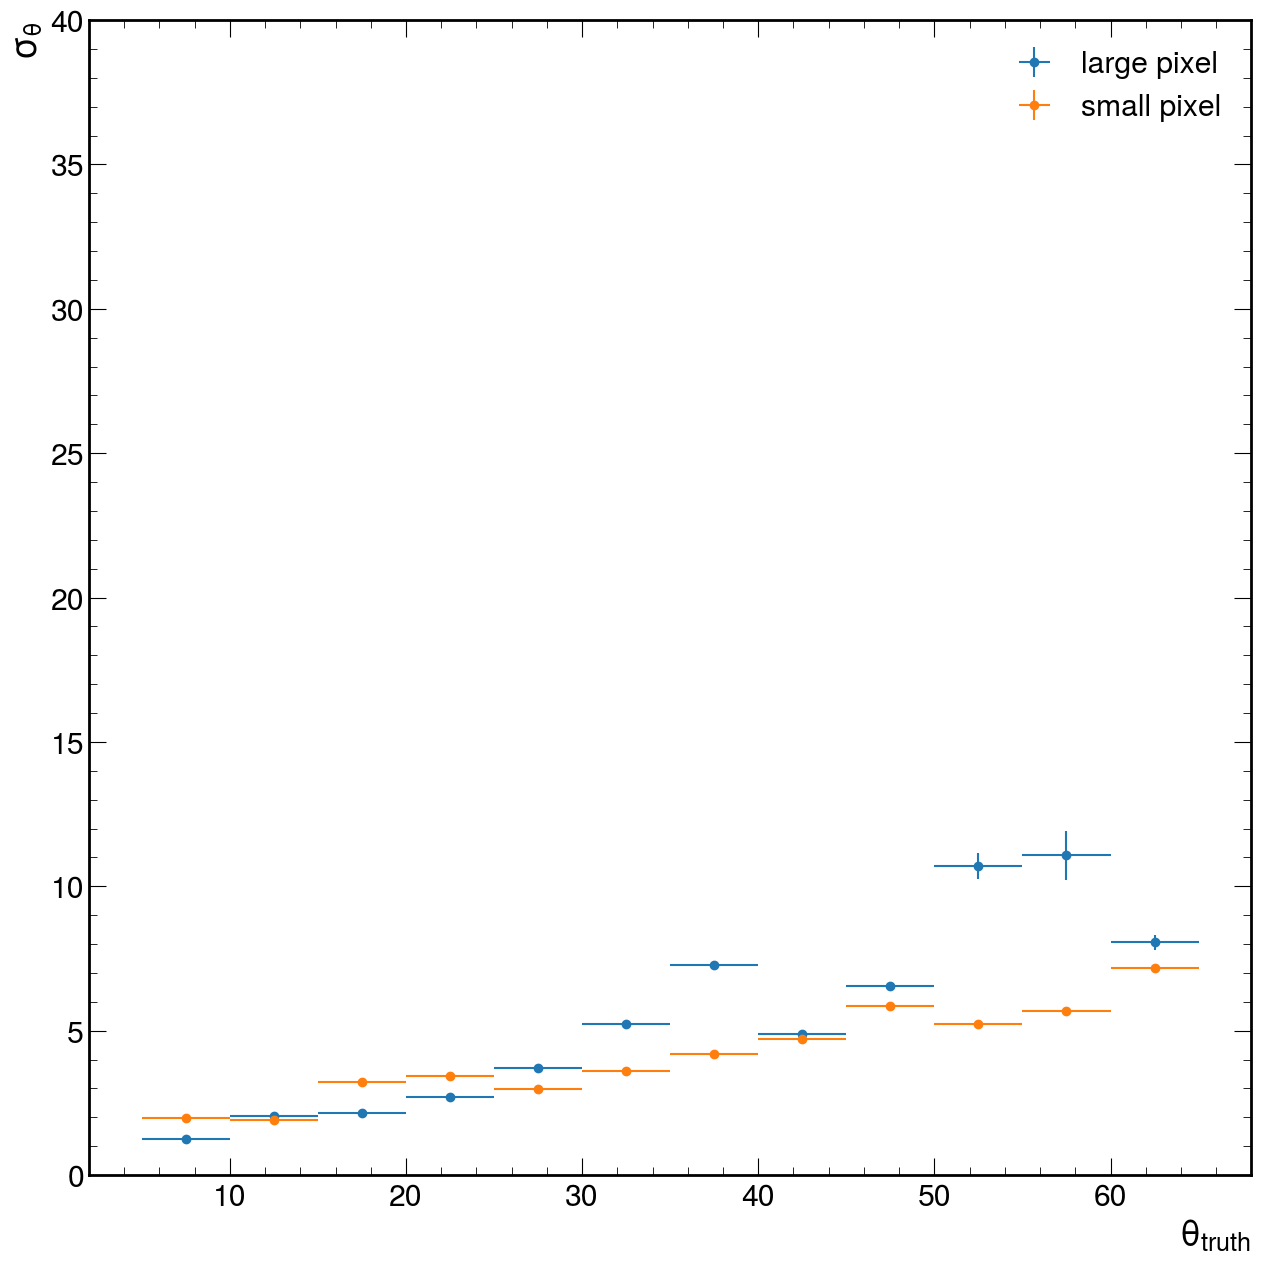

In [54]:
plt.figure(figsize=(15,15))
labels = ['large pixel','small pixel']
for j in range(2):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,2][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,yerr=error[j*12:(j+1)*12],label=f'{labels[j]}',fmt='o')
plt.ylabel(r'$\sigma_{\theta}$')
plt.xlabel(r'$\theta_{truth}$')

plt.ylim(bottom=0,top=40)
plt.legend()
plt.savefig('ThetaResolution_sigma.png',format='png')

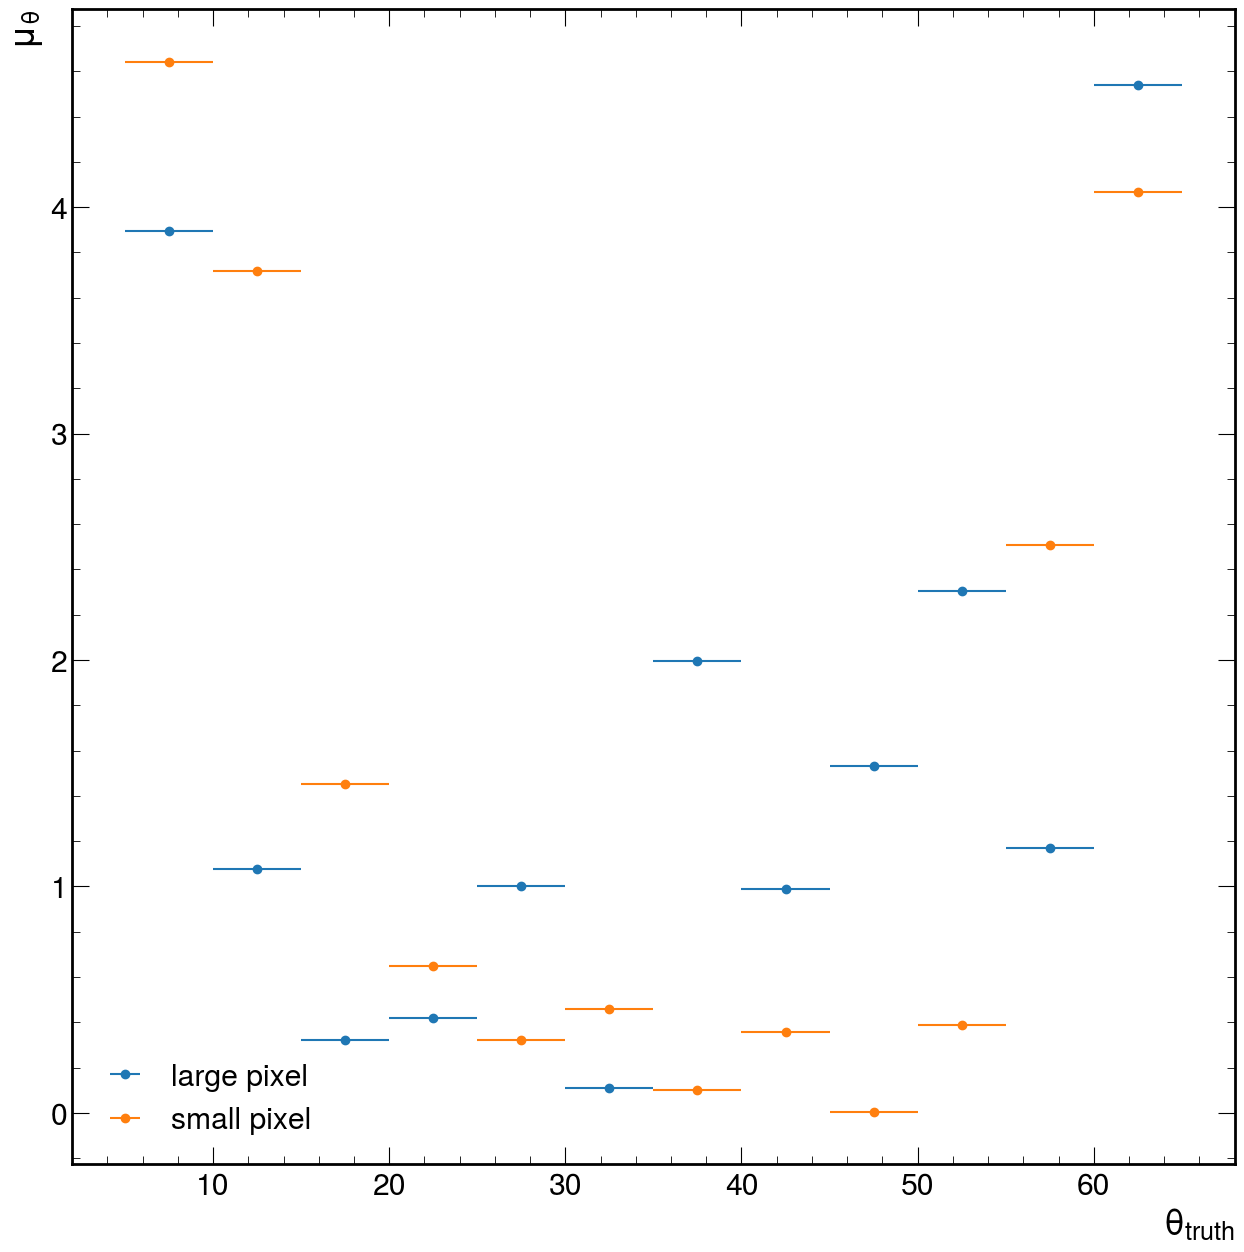

In [55]:
plt.figure(figsize=(15,15))
for j in range(2):
    plt.errorbar(bins[:12],abs(np.array(fits)[:,1][j*12:(j+1)*12]),xerr=(bins[1]-bins[0])/2,label=f'{labels[j]}',fmt='o')

plt.ylabel(r'$\mu_{\theta}$')
plt.xlabel(r'$\theta_{truth}$')

#plt.ylim(bottom=0)
plt.legend()
plt.savefig('ThetaResolution_mu.png',format='png')

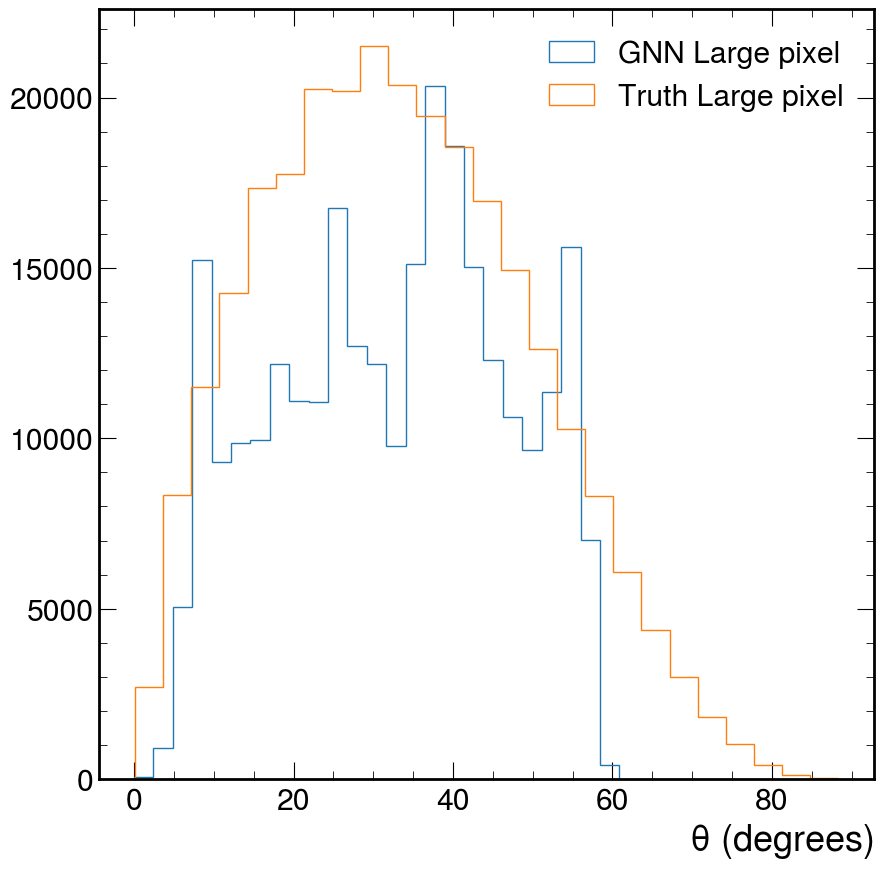

In [60]:
plt.hist(gnn_large,label='GNN Large pixel',histtype='step',bins=25)
plt.hist(truth_large,label='Truth Large pixel',histtype='step',bins=25)
plt.xlabel(r'$\theta$ (degrees)')
plt.legend()